In [ ]:
# Higgs-boson simulation using CUDA
# Edit -> Notebook settings -> T4 GPU must be enabled

# For more information see Higgs-Boson-elsevier-9.pdf

# setup required library CuPy to work on the GPU
import locale
locale.getpreferredencoding = lambda: "UTF-8"

##!pip uninstall cupy-cuda12x

!pip install cupy-cuda12x --quiet # cupy is the library that works on GPUs
!pip install alive_progress --quiet
!pip install pyevtk --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 944.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Starting 1000 time steps, output at every 1000 step.
|████████████████████████████████████████| 1000/1000 [100%] in 52.4s (19.32/s)  


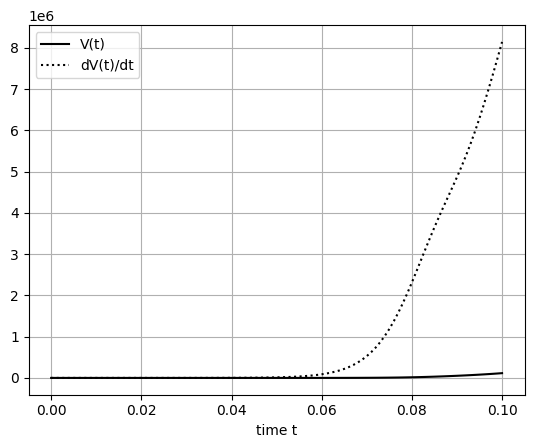

In [ ]:
# load numerical libraries
import numpy as np
import cupy as cp
import math
import matplotlib.pyplot as plt
from alive_progress import alive_bar
from pyevtk.hl import imageToVTK
import glob
import os

###### Parameters ###################
N=301; # number of grid points in space (same uniform in all three directions x,y,z)
dx=1.0/(N-1); # Delta x = Delta y = Delta z step size in space
dt=0.0001; # step size in time (have to experiment with this)
Nt_max=1000; # maximum number of time steps. The more steps the more time it takes!
Nt_freq=1000; # saving the solution w(t,x,y,z) at every Nt_freq steps. Never if Nt_freq > Nt_max.
E_freq=10; # Lyapunov output frequency Never if E_freq > Nt_max. (this is where V(t) will be used)

# see Higgs-Boson-elsevier-9.pdf
L = 1.0; # scaling of space (from unit cube to cube with side lengths L)
Ldx=L*dx
mu_2 = 10000.0; # \mu^2
llambda = 0.1; # lambda
# need two initial conditions at t=0:
# w(x,y,z,0) called the first initial condition
# w_t(x,y,z,0) called the second initial condition
N_spikes=1; # number of spikes (bump function) for the initial conditions
amps=[1.0, 2.0]; # amplitudes of the spike(s) (heights)
# x,y,z coordinates of the center of the spikes inside the !!unit cube!!
cx=[0.5, 0.6]; cy=[0.5, 0.6]; cz=[0.5, 0.6];
radius2s=[ 0.04, 0.04]; # squared radii of the spikes
cdwdt=0.0; # multiplier for initial condition w_t(x,y,z,0) = cdwdt * w(x,y,z,0)

w=cp.zeros((N,N,N), dtype=cp.float32); # w_ijk = w[i,j,k] 3-dimensional tensor
wt=cp.zeros_like(w) # time derivative w_t

# Runge-kutta (45) method needs the following for w and w_t
k11=cp.zeros_like(w); k12=cp.zeros_like(w);
k21=cp.zeros_like(w); k22=cp.zeros_like(w);
k31=cp.zeros_like(w); k32=cp.zeros_like(w);
k41=cp.zeros_like(w); k42=cp.zeros_like(w);

V=np.zeros(int(Nt_max/E_freq)+1, dtype=np.float32) # Lyapunov function
VP=cp.zeros_like(w); # Inside of the integral in the Lyapunov function
# the integral of this becomes the Lyapunov function (Pointvise at x,y,z or i,j,k)
d_V=np.zeros_like(V) # d_Lyapunov function
d_VP=cp.zeros_like(w); # Inside of the integral in the d_Lyapunov function

fileList = glob.glob('out*.vti')
# Iterate over the list of filepaths & remove each file.
for filePath in fileList:
  try:
    os.remove(filePath)
  except:
    print("Error while deleting file : ", filePath)


# These are needed to set up and distribute computation on the GPU
# See CUDA grid and block
block_size_x, block_size_y, block_size_z = 8,8,8 #tune to your needs
gridx = N // block_size_x + 1 * (N % block_size_x != 0)
gridy = N // block_size_y + 1 * (N % block_size_y != 0)
gridz = N // block_size_z + 1 * (N % block_size_z != 0)
grids = (gridx, gridy, gridz)
blocks = (block_size_x, block_size_y, block_size_z)

# CUDA C++ kernel functions handle tensors (multidimensional arrays) like w[i,j,k]
# by flatting them to get one-dimensional array w[i+j*N+k*N*N]

# Definition w(x,y,z,0) first initial data as a CUDA-C++ kernel function
init_data1 = cp.RawKernel(r'''
   extern "C" __global__
   void init_data1(const int N, float* w, float radius2, float dx, float cx,
                   float cy, float cz, float amps){
      float xyz; /* R^2 - |x-C|^2 in the denominator */
      int i = blockDim.x*blockIdx.x + threadIdx.x;
      int j = blockDim.y*blockIdx.y + threadIdx.y;
      int k = blockDim.z*blockIdx.z + threadIdx.z;
      /* On the boundary the values are zeros */
      if((i>1)&&(i<N-3)&&(j>1)&&(j<N-3)&&(k>1)&&(k<N-3)){
         /* xyz= R^2 - |x-C|^2 in the denominator */
         /* x=i*dx, y=j*dx, z=k*dx */
         xyz=radius2-powf(i*dx-cx,2.0)-powf(j*dx-cy,2.0)-powf(k*dx-cz,2.0);
         if(xyz>0.0){
            w[i+j*N+k*N*N] = w[i+j*N+k*N*N] + amps*exp((xyz-radius2)/(radius2*xyz));
         }
      }
   }
     ''', 'init_data1')

# Definition w_t(x,y,z,0) = cdwdt * w(x,y,z,0) second initial data as a CUDA-C++ kernel function
init_data2 = cp.RawKernel(r'''
   extern "C" __global__
   void init_data2(const int N, float* w, float* wt, float cdwdt){
      int i = blockDim.x*blockIdx.x + threadIdx.x;
      int j = blockDim.y*blockIdx.y + threadIdx.y;
      int k = blockDim.z*blockIdx.z + threadIdx.z;
      if((i>1)&&(i<N-3)&&(j>1)&&(j<N-3)&&(k>1)&&(k<N-3)){
         wt[i+j*N+k*N*N] =cdwdt * w[i+j*N+k*N*N];
      }
   }
     ''', 'init_data2')


# evaluate right-hand side function for the Runge-Kutta method
# y' = f(t,y) =>  [w, w_t] = f(t, w, w_t)
# [kn1, kn2] = f(t+h,w+ko1*h,wt+ko2*h)
eval_f = cp.RawKernel(r'''
   extern "C" __global__
   void eval_f(const int N, float* w, float* wt, float *kn1, float *kn2,
       float *ko1, float *ko2, float c1, float c2, float c3, float llambda,
       float h){
      int i = blockDim.x*blockIdx.x + threadIdx.x;
      int j = blockDim.y*blockIdx.y + threadIdx.y;
      int k = blockDim.z*blockIdx.z + threadIdx.z;
      if((i>1)&&(i<N-3)&&(j>1)&&(j<N-3)&&(k>1)&&(k<N-3)){
         kn1[i+j*N+k*N*N]=wt[i+j*N+k*N*N]+h*ko2[i+j*N+k*N*N];
         kn2[i+j*N+k*N*N]=c1*(w[i+j*N+k*N*N]+h*ko1[i+j*N+k*N*N])
             -llambda*(powf(w[i+j*N+k*N*N]+h*ko1[i+j*N+k*N*N],3.0))
             -3.0*(wt[i+j*N+k*N*N]+h*ko2[i+j*N+k*N*N])
             +c2*(w[(i+2)+j*N+k*N*N]+w[(i-2)+j*N+k*N*N]+w[i+(j+2)*N+k*N*N]
             +w[i+(j-2)*N+k*N*N] + w[i+j*N+(k+2)*N*N] +w[i+j*N+(k-2)*N*N])
             +c2*h*(ko1[(i+2)+j*N+k*N*N]+ko1[(i-2)+j*N+k*N*N]
             +ko1[i+(j+2)*N+k*N*N] + ko1[i+(j-2)*N+k*N*N]
             + ko1[i+j*N+(k+2)*N*N]  +ko1[i+j*N+(k-2)*N*N])
             +c3*(w[(i+1)+j*N+k*N*N]+w[(i-1)+j*N+k*N*N]+w[i+(j+1)*N+k*N*N]
                +w[i+(j-1)*N+k*N*N]+w[i+j*N+(k+1)*N*N]+w[i+j*N+(k-1)*N*N])
             +c3*h*(ko1[(i+1)+j*N+k*N*N]+ko1[(i-1)+j*N+k*N*N]
                +ko1[i+(j+1)*N+k*N*N]+ko1[i+(j-1)*N+k*N*N]
                +ko1[i+j*N+(k+1)*N*N] +ko1[i+j*N+(k-1)*N*N]);
      }
   }
     ''', 'eval_f')

# Runge-Kutta method
# advance w = w + (dt/6)*(k11 + 2*k21 + 2*k31 + k41)
# advance w_t = w_t + (dt/6)*(k12 + 2*k22 + 2*k32 + k42)
# CuPy elementwise kernel function to calculate w, w_t at evey point [i,j,k]
advance_rungekutta=cp.ElementwiseKernel( in_params="float32 k11,"
      "float32 k12, float32 k21, float32 k22, float32 k31, float32 k32,"
      "float32 k41, float32 k42, float32 dt",
    out_params="float32 w, float32 wt",
    operation="w=w+(k11+2.0*(k21+k31)+k41)*dt/6.0;"
               "wt=wt+(k12+2.0*(k22+k32)+k42)*dt/6.0;",
                                         no_return=True,
                                         name="advance_rungekutta")

# Pointwise quantities for the integration of Lyapunov function
# Use equations (31)-(34) without the summation
pointwise_Lyapunov = cp.RawKernel(r'''
   extern "C" __global__
   void pointwise_Lyapunov(const int N, float* w, float* wt, float* VP,
                           float mu_2, float lambda, float t, float dx){
      int i = blockDim.x*blockIdx.x + threadIdx.x;
      int j = blockDim.y*blockIdx.y + threadIdx.y;
      int k = blockDim.z*blockIdx.z + threadIdx.z;
      if((i>1)&&(i<N-3)&&(j>1)&&(j<N-3)&&(k>1)&&(k<N-3)){
        VP[i+j*N+k*N*N] = mu_2 * powf(w[i+j*N+k*N*N],2.0)
            - powf( wt[i+j*N+k*N*N], 2.0)
           - (lambda/2.0) * powf(w[i+j*N+k*N*N],4.0)
          - exp(-2.0*t) * powf((-w[i+2+j*N+k*N*N]+8.0*w[i+1+j*N+k*N*N]
          - 8.0*w[i-1+j*N+k*N*N]+w[i-2+j*N+k*N*N])/(12.0*dx), 2.0)
          - exp(-2.0*t) * powf((-w[i+(j+2)*N+k*N*N]+8.0*w[i+(j+1)*N+k*N*N]
          - 8.0*w[i+(j-1)*N+k*N*N]+w[i+(j-2)*N+k*N*N])/(12.0*dx), 2.0)
          - exp(-2.0*t) * powf((-w[i+j*N+(k+2)*N*N]+8.0*w[i+j*N+(k+1)*N*N]
          - 8.0*w[i+j*N+(k-1)*N*N]+w[i+j*N+(k-2)*N*N])/(12.0*dx),2.0 );
      }
   }
''', 'pointwise_Lyapunov')




pointwise_d_Lyapunov = cp.RawKernel(r'''
   extern "C" __global__
   void pointwise_d_Lyapunov(const int N, float* w, float* wt, float* d_VP,
                            float t, float dx){
      int i = blockDim.x*blockIdx.x + threadIdx.x;
      int j = blockDim.y*blockIdx.y + threadIdx.y;
      int k = blockDim.z*blockIdx.z + threadIdx.z;
      if((i>1)&&(i<N-3)&&(j>1)&&(j<N-3)&&(k>1)&&(k<N-3)){
        d_VP[i+j*N+k*N*N] = 6*powf( wt[i+j*N+k*N*N], 2.0)+
          +2 *exp(-2.0*t) * powf((-w[i+2+j*N+k*N*N]+8.0*w[i+1+j*N+k*N*N]
          - 8.0*w[i-1+j*N+k*N*N]+w[i-2+j*N+k*N*N])/(12.0*dx), 2.0)
          +2* exp(-2.0*t) * powf((-w[i+(j+2)*N+k*N*N]+8.0*w[i+(j+1)*N+k*N*N]
          - 8.0*w[i+(j-1)*N+k*N*N]+w[i+(j-2)*N+k*N*N])/(12.0*dx), 2.0)
          +2* exp(-2.0*t) * powf((-w[i+j*N+(k+2)*N*N]+8.0*w[i+j*N+(k+1)*N*N]
          - 8.0*w[i+j*N+(k-1)*N*N]+w[i+j*N+(k-2)*N*N])/(12.0*dx),2.0);
      }
   }
''', 'pointwise_d_Lyapunov')


##### END OF SETTING UP Subroutines and functions #########

# first initial data w(x,y,z,0), set up spikes (bump functions)
# by calling the CUDA C++ kernel functions
for spike in range(N_spikes):
    init_data1(grids, blocks, (N, w, cp.float32(radius2s[spike]),
                               cp.float32(dx), cp.float32(cx[spike]),
                               cp.float32(cy[spike]), cp.float32(cz[spike]),
                               cp.float32(amps[spike])))

# second initial data w_t(x,y,z,0)
init_data2(grids, blocks, (N, w, wt, cp.float32(cdwdt)))


# output solution w if needed
if Nt_freq <= Nt_max:
  # save w into a vtk file (open with paraview)
  imageToVTK("out{:03d}".format(0), pointData = {"higgs" : w.get()} )
  #print(cp.max(w))

# initial at t=0
pointwise_Lyapunov(grids, blocks, (N, w, wt, VP, cp.float32(mu_2),
                  cp.float32(llambda), cp.float32(0), cp.float32(dx)))
V[0]=(Ldx**3)*cp.sum(VP).get()   # get() from GPU to CPU
pointwise_d_Lyapunov(grids, blocks, (N, w, wt, d_VP, cp.float32(0.0),
                                     cp.float32(dx)))
d_V[0]=(Ldx**3)*cp.sum(d_VP).get()   # get() from GPU to CPU

print(f"Starting {Nt_max} time steps, output at every {Nt_freq} step.")

with alive_bar(Nt_max, force_tty=True) as bar: # progress bar
  for step in range(1,Nt_max+1):  # number of time steps for Runge-Kutta
    # k1 = f(t,y(t))
    rt=math.exp(-2.0*step*dt)/(Ldx**2);
    c1 = mu_2-7.5*rt; c2 = -rt/12.0; c3=rt*4.0/3.0; dtp2=0.0
    eval_f(grids, blocks, (N, w, wt, k11, k12, k11, k12, cp.float32(c1),
                           cp.float32(c2), cp.float32(c3),
                           cp.float32(llambda), cp.float32(dtp2)))
    # k2 = f(t+h/2,y(t)+k1*h/2)
    rt=math.exp(-2.0*step*dt-dt)/(L*L*dx*dx);
    c1=mu_2-7.5*rt; c2=-rt/12.0; c3=rt*4.0/3.0; dtp2=dt/2.0
    eval_f(grids, blocks, (N, w, wt, k21, k22, k11, k12, cp.float32(c1),
                           cp.float32(c2), cp.float32(c3),
                           cp.float32(llambda), cp.float32(dtp2)))
    # k3 = f(t+h/2,y(t)+k2*h/2)
    eval_f(grids, blocks, (N, w, wt, k31, k32, k21, k22, cp.float32(c1),
                           cp.float32(c2), cp.float32(c3),
                           cp.float32(llambda), cp.float32(dtp2)))
    # k4 = f(t+h,y(t)+k3*h)
    rt=math.exp(-2.0*(step*dt+dt))/(L*L*dx*dx);
    c1=mu_2-7.5*rt; c2=-rt/12.0; c3=rt*4.0/3.0; dtp2=dt;
    eval_f(grids, blocks, (N, w, wt, k41, k42, k31, k32, cp.float32(c1),
                          cp.float32(c2), cp.float32(c3),
                          cp.float32(llambda), cp.float32(dtp2)))

    #  advance to next time step: y(t+h) = y(t)+(k1+2*k2+2*k3+k4)*h/6
    advance_rungekutta(k11, k12, k21, k22, k31, k32, k41, k42, dt, w, wt)

    if (math.fmod(step,Nt_freq)==0.0):  # save w to vtk file
        imageToVTK("out{:03d}".format(int(step/Nt_freq)), pointData = {"higgs" : w.get()} )

    if step%E_freq==0: # Lyapunov function
      t = step*dt
      pointwise_Lyapunov(grids, blocks, (N, w, wt, VP, cp.float32(mu_2),
                    cp.float32(llambda), cp.float32(t) , cp.float32(Ldx)))
      V[int(step/E_freq)]=(Ldx**3)*(cp.sum(VP)).get()       # save V(t) in a vector
      pointwise_d_Lyapunov(grids, blocks, (N, w, wt, d_VP, cp.float32(t),
                                           cp.float32(Ldx)))
      d_V[int(step/E_freq)]=(Ldx**3)*(cp.sum(d_VP)).get()
    bar()

##### Plot results ############
t = np.linspace(0, Nt_max*dt, int(Nt_max/E_freq)+1)
plt.plot(t, V, 'k', t, d_V, 'k:')
plt.grid()
plt.xlabel("time t")
#plt.ylabel("Lyapunov function")
plt.legend(["V(t)", "dV(t)/dt"])

In [ ]:
print(V)

[9.31894481e-01 9.55809653e-01 1.18693554e+00 2.73413610e+00
 1.25736341e+01 7.52579651e+01 4.75606018e+02 2.95381006e+03
 1.55901104e+04 5.17645625e+04 1.15986328e+05 2.19835094e+05
 3.67509500e+05 5.67249562e+05 8.30218938e+05 1.16308650e+06
 1.57566925e+06 2.07206450e+06 2.66210250e+06 3.35394750e+06
 4.15481350e+06 5.07306000e+06 6.11363500e+06 7.28775750e+06
 8.59879600e+06 1.00604660e+07 1.16752130e+07 1.34556290e+07
 1.54249090e+07 1.76045580e+07 1.99922240e+07 2.25346560e+07
 2.54445340e+07 2.83084620e+07 3.11770900e+07 3.42062560e+07
 3.71592480e+07 4.06150640e+07 4.39956560e+07 4.76413120e+07
 5.17450000e+07 5.57675920e+07 6.01168440e+07 6.48925560e+07
 6.91249200e+07 7.37689760e+07 7.83642320e+07 8.32996480e+07
 8.86534080e+07 9.45438720e+07 1.00037008e+08 1.05889728e+08
 1.12093864e+08 1.17172280e+08 1.22380520e+08 1.27155392e+08
 1.32700184e+08 1.38178992e+08 1.43910384e+08 1.49310224e+08
 1.55542064e+08 1.62950784e+08 1.68271744e+08 1.74266016e+08
 1.79777872e+08 1.847230

In [ ]:
from google.colab import files
files.download("out003.vti")
files.download("out002.vti")
files.download("out001.vti")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

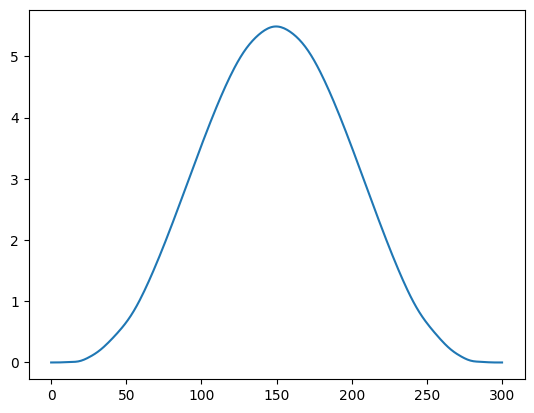

In [ ]:
#print(w.diagonal(0,1,2).diagonal().shape)
plt.plot(w.diagonal(0,1,2).diagonal().get())
#a = np.arange(8).reshape(2,2,2);
#print(a)
#a.diagonal(0,1,2).diagonal()